In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [270]:
class CrossEntropyLoss:
    @staticmethod
    def loss(y_pred, y_true):
        return -(y_true*np.log(y_pred)).sum()

    @staticmethod
    def loss_(y_pred, y_true):
        return -y_true/y_pred
#         if y_pred.ndim > 1:
#             return 2 *((np.subtract(y_pred, y_true)).mean(0))
#         else: 
#             return 2 *np.subtract(y_pred, y_true)


class Sigmoid:
    @staticmethod
    def apply(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def apply_(x):
        # calculate the derivative of the sigmoid funciton
        return np.outer(x, (1 - x))
#         return Sigmoid.apply(x)*(1-Sigmoid.apply(x))
#         return np.exp(-x)/((1+np.exp(-x))**2)
    
class Softmax:
    @staticmethod
    def apply(x):
        return np.exp(x)/(np.exp(x).sum())
    
    def apply_(x): # TODO check
        return np.eye(x.shape[0]) * x - np.outer(x, x)
#         return np.exp(x) / sum(np.exp(x)) * (1. - np.exp(x) / sum(np.exp(x)))
#         return np.eye(x.shape[0])*Softmax.apply(x) - np.outer(Softmax.apply(x),  Softmax.apply(x))

In [286]:
class Layer:
    def __init__(self, weights, bias=None, activation_function=Sigmoid):
        # you can choose whether to to add bias manually or not use it
        self.weights = weights
#         if bias is None:
#             self.bias = np.zeros(self.weights.shape[0])
#         else:
#             self.bias = bias
        self.act_func = activation_function
#         self.check_shape_weights_bias()


    def apply(self, x_in):
        # calculate the layer output given x_in using layer weights and bias
        # save x_in and x_out for backwards pass
        x_out = np.dot(self.weights, x_in) #+ self.bias
        self.x_out = x_out
        self.x_in = x_in
        return self.act_func.apply(x_out)
    
#     def loss(self, downstream_grad):
        
    
    def backwards(self, downstream_grad): #TODO to bias
        function_derivative = self.act_func.apply_(self.x_out)
        # calculate the gradient of the layer weights and pad on the gradient to upstream layers
        x_out_grad = self.act_func.apply_(self.x_out)
        downstream_grad = downstream_grad * x_out_grad
        self.weights_grad = np.outer(downstream_grad, self.x_in) #TODO use it for gradient descent
#         self.weights_grad = downstream_grad @  self.x_in
        self.bias_grad = downstream_grad
        downstream_grad = downstream_grad @ self.weights
        return downstream_grad

    def check_shape_weights_bias(self):
        if self.weights.shape[0] != self.bias.shape[0]:
            raise ValueError('Incorrect size of weights and bias. '
                            'weights.shape', self.weights.shape, 'bias.shape', self.bias.shape)

In [442]:
class Network:
    # initialize the network with the given layers
    def __init__(self, layers=None, loss_func=CrossEntropyLoss):
        if layers is None:
            self.layers = []
        else:
            self.layers = layers
        self.check_size_layers()
        self.lossfunc = loss_func

    def add_layer(self, new_layer):
        # add a layer to the network, checks it is correct size
        self.layers.append(new_layer)
        self.check_size_layers()

#     def remove_layer(self, index):
#         # removes layer, check if sizes make sense
#         self.layers.pop(index)
#         self.check_size_layers()

#     def add_layer_in(self, new_layer, pos):
#         # adds a layer in some position, checks the correct size
#         self.layers.insert(pos, new_layer)
#         self.check_size_layers()

    def forward(self, x):
        # do a forwark pass of the network on the given input
        x_out = self.layers[0].apply(x)
        for i in range(1, len(self.layers)):
            x_out = self.layers[i].apply(x_out)
        return x_out

    def forward_multiple_input(self, multiple_x):
        # performs multiple input
        multiple_x_out = []
        for j in range(len(multiple_x)):
            multiple_x_out.append(self.forward(multiple_x[j]))
        return multiple_x_out
    
    def backwards(self, loss_grad):
        # do a backwards pass and calculate the network gradients
        # loop through all layers in reverse order and call backwards func
        downstream_grad = loss_grad
        for layer in reversed(self.layers):
            downstream_grad = layer.backwards(downstream_grad)
#         return downstream_grad

    def check_size_layers(self):
        # check the correct sizes of weights between layers
        for i in range(1, len(self.layers)):
            if self.layers[i-1].weights.shape[0] != self.layers[i].weights.shape[1]:
                raise ValueError('Incorrect sizes of layers',
                                self.layers[i-1].weights.shape, 'vs', self.layers[i].weights.shape)


    def train(self, inputs, outputs, epochs=1, learning_rate=0.1):
        print('inputs', inputs.shape, 'outputs', outputs.shape)
        loss=0
        for epoch in range(epochs):
            loss=0
            for i_out in range(len(inputs)):            
                y_pred = np.array(self.forward(inputs[i_out]))
#                 print(y_pred)
                loss = CrossEntropyLoss.loss(y_pred, outputs[i_out])
                loss_ = CrossEntropyLoss.loss_(y_pred, outputs[i_out])

                softmax_der = (np.eye(y_pred.shape[0]) * y_pred - np.outer(y_pred, y_pred))
                downstream_grad = loss_ @ softmax_der
                w3up = np.outer(downstream_grad, self.layers[2].x_in)

                sigmoid_der = np.outer(self.layers[2].x_in, (1 - self.layers[2].x_in ))
                downstream_grad = (downstream_grad @ self.layers[2].weights @ sigmoid_der)
                w2up = np.outer(downstream_grad, self.layers[1].x_in)

                sigmoid_der = np.outer(self.layers[1].x_in, (1 - self.layers[1].x_in ))
                downstream_grad = (downstream_grad @ self.layers[1].weights @ sigmoid_der)
                w1up = np.outer(downstream_grad, self.layers[0].x_in)

                loss += loss/inputs.shape[0] 

    #             print(self.layers[2].weights[0][0])
    #             print(max(w3up[0]))
    #             print(w3up[0][0] * learning_rate)
                self.layers[2].weights -= w3up * learning_rate
                self.layers[1].weights -= w2up * learning_rate
                self.layers[0].weights -= w1up * learning_rate
    #             for layer in self.layers:
    #                 layer.weights -= layer.weights_grad * learning_rate
    # #                 print(layer.bias_grad)
    # #                 print(layer.bias)
    #                 layer.bias -= layer.bias_grad *learning_rate 

            if epoch %(epochs/10) == 0:
                print(epoch, 'CrossEntropyLoss', loss)

In [381]:
def calculate_accuracy(predict_proba, y):
    """
    Calculates the accuracy of the prediction
    :param predict_proba: the probabilities of each class
    :param y:  true labels
    :return: acc accuracy
    """
    y_pred = predict_proba.argmax(axis=1)
    acc = (y_pred == y).sum() / y.shape[0]
    return acc

In [342]:
# ls

In [325]:
# pip install torch

In [326]:
# pip install torchvision

In [327]:
# import torch
# import torchvision
# import torchvision.datasets as datasets

In [328]:
# mnist_trainset = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=None)

In [329]:
# mnist_trainset[0]

In [330]:
train_df = pd.read_csv('archive/mnist_train.csv')

In [331]:
X = train_df.iloc[:, 1:]
assert not'label' in X.columns
X = X.to_numpy()
y = train_df['label']

In [332]:
X.shape

(60000, 784)

In [465]:
# Creating network
weights = np.random.normal(size=(300, X.shape[1]))/X.shape[1]
l1 = Layer(weights, None, Sigmoid)
weights = np.random.normal(size=(200, 300))/X.shape[1]
l2 = Layer(weights, None, Sigmoid)
weights = np.random.normal(size=(10, 200))/X.shape[1]
l3 = Layer(weights, None, Softmax)
net = Network([l1, l2, l3])

# Calculating accuracy
predict_proba = np.array(net.forward_multiple_input(X))
acc = calculate_accuracy(predict_proba, y)
print('Accuracy:', acc)

Accuracy: 0.11236666666666667


In [454]:
batch = 64

In [455]:
one_hots = []
for yi in y:
    one_hots.append([1 if _==yi else 0 for _ in range(10)])
one_hots = np.array(one_hots)

In [466]:
net.train(X, one_hots, 5, 0.00001)
predict_proba = np.array(net.forward_multiple_input(X))
acc = calculate_accuracy(predict_proba, y)
print('Accuracy:', acc)

inputs (60000, 784) outputs (60000, 10)


<ipython-input-270-e38cc5d9cd59>:18: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


0 CrossEntropyLoss 2.3720041529815856
1 CrossEntropyLoss 2.3857377628459977
2 CrossEntropyLoss 2.356270712266509
3 CrossEntropyLoss 2.339652253020851
4 CrossEntropyLoss 2.3400719721715837
Accuracy: 0.11236666666666667


In [457]:
print('Accuracy:', acc)

Accuracy: 0.10441666666666667


In [253]:
acc

0.09871666666666666

In [229]:
predict_proba = np.array(net.forward_multiple_input(X))
acc = calculate_accuracy(predict_proba, y)
print('Accuracy:', acc)

Accuracy: 0.09035


In [218]:
y_pred = np.array(net.forward(X[0]))
loss_ = CrossEntropyLoss.loss_(y_pred, y[0])

softmax_der = (np.eye(y_pred.shape[0]) * y_pred - np.outer(y_pred, y_pred))
downstream_grad = loss_ @ softmax_der
w3up = np.outer(downstream_grad, l3.x_in)

sigmoid_der = np.outer(l3.x_in, (1 - l3.x_in ))
downstream_grad = (downstream_grad @ l3.weights @ sigmoid_der)
w2up = np.outer(downstream_grad, l2.x_in)

sigmoid_der = np.outer(l2.x_in, (1 - l2.x_in ))
downstream_grad = (downstream_grad @ l2.weights @ sigmoid_der)
w1up = np.outer(downstream_grad, l1.x_in)

# USING PYTORCH

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [184]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 10)
        
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.uniform_(-1, 1)
#             module.weight.data.fill_(0)
#             module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.fill_(0)
#                 module.bias.data.zero_()

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x


net = Net()

In [186]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

losses = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
    for batch_i in range(0, X.shape[0], batch):
        inputs = torch.tensor(X[batch_i:batch_i + batch]).to(torch.float32)
        labels = torch.tensor(one_hots[batch_i:batch_i + batch]).to(torch.float32)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_i % 50000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {batch_i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

<ipython-input-184-d999faca8c6a>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


[1,     1] loss: 0.001
[1, 50001] loss: 0.579
[2,     1] loss: 0.001
[2, 50001] loss: 0.570
[3,     1] loss: 0.001
[3, 50001] loss: 0.561
[4,     1] loss: 0.001
[4, 50001] loss: 0.551
[5,     1] loss: 0.001
[5, 50001] loss: 0.541
[6,     1] loss: 0.001
[6, 50001] loss: 0.534
[7,     1] loss: 0.001
[7, 50001] loss: 0.528
[8,     1] loss: 0.001
[8, 50001] loss: 0.524
[9,     1] loss: 0.001
[9, 50001] loss: 0.519
[10,     1] loss: 0.001
[10, 50001] loss: 0.516
[11,     1] loss: 0.001
[11, 50001] loss: 0.512
[12,     1] loss: 0.001
[12, 50001] loss: 0.509
[13,     1] loss: 0.001
[13, 50001] loss: 0.506
[14,     1] loss: 0.001
[14, 50001] loss: 0.504
[15,     1] loss: 0.001
[15, 50001] loss: 0.502
[16,     1] loss: 0.001
[16, 50001] loss: 0.500
[17,     1] loss: 0.001
[17, 50001] loss: 0.498
[18,     1] loss: 0.001
[18, 50001] loss: 0.496
[19,     1] loss: 0.001
[19, 50001] loss: 0.494
[20,     1] loss: 0.001
[20, 50001] loss: 0.493
Finished Training


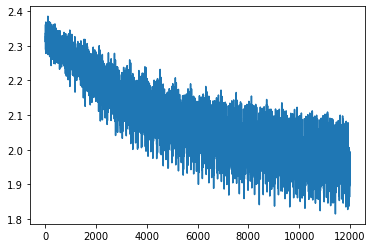

In [187]:
# uniform distributed

plt.plot(losses)

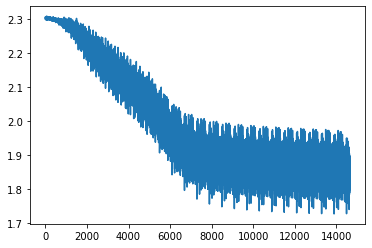

In [183]:
# normal distributed weights
plt.plot(losses)

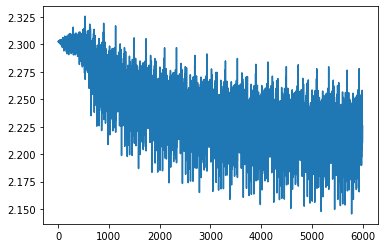

In [167]:
# zero init weights

plt.plot(losses)

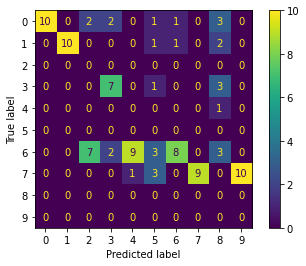

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(outputs.argmax(axis=1) , labels.argmax(axis=1), labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-118-0860eca73b57>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


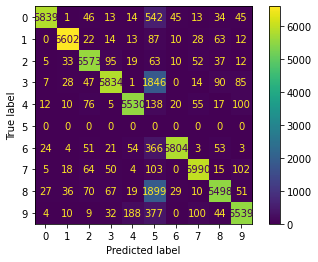

In [124]:
inputs = torch.tensor(X).to(torch.float32)
labels = torch.tensor(one_hots).to(torch.float32)

outputs = net(inputs)
cm = confusion_matrix(outputs.argmax(axis=1) , labels.argmax(axis=1), labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();

In [ ]:
test_df = pd.read_csv('archive/mnist_test.csv')
X_test = test_df.iloc[:, 1:]
assert not'label' in X_test.columns
X_test = X_test.to_numpy()
y_test = test_df['label']

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-145-0860eca73b57>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


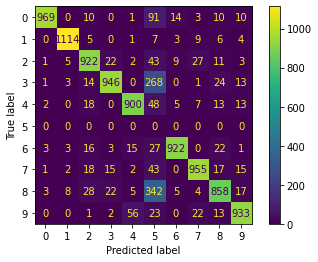

In [159]:
inputs_test = torch.tensor(X_test).to(torch.float32)

outputs_test = net(inputs_test)

cm = confusion_matrix(outputs_test.argmax(axis=1) , y_test, labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();